# Satellite imagery building segmentation MaskRCNN 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks
!pip install mrcnn
%tensorflow_version 1.x

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=bd55bac75fb4b64e6b2c9601bb149d45cacbfe713ea1b92cd1e016c7c42bc7db
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
TensorFlow 1.x selected.


# Train

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage.draw
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

# local python file:
import semantic_utils


print(f"Tensorflow version: {tf.__version__}")

ROOT_DIR = os.path.dirname(os.getcwd())
print(f"Root directory: {ROOT_DIR}")
LOGS_DIR = os.path.join(ROOT_DIR, "MASK_RCNN", "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "MASK_RCNN", "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/ucsail/anaconda3/envs/SAIL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ucsail/anaconda3/envs/SAIL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ucsail/anaconda3/envs/SAIL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ucsail/anaconda3/envs/SAIL/lib/python3.6/site-

Tensorflow version: 1.12.0
Root directory: /home/ucsail/rural_images


Using TensorFlow backend.


In [3]:
############################################################
#  Configurations
############################################################


class LandCoverConfig(Config):
    """
    Includes 2 labelled classes (water and vegetation) and the background
    """
    NAME = "LandCover"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2

    STEPS_PER_EPOCH = 2000

    DETECTION_MIN_CONFIDENCE = 0.9
    
    LEARNING_RATE = 0.001

config = LandCoverConfig()
# config.display()

In [4]:
############################################################
#  Dataset
############################################################

class LandCoverDataset(utils.Dataset):

    def load_LandCover(self, dataset_dir, subset):
        """Load a subset of the LandCover dataset.  
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.add_class("LandCover", 1, "water")
        self.add_class("LandCover", 2, "vegetation")
        
        assert subset in ["train", "train_aug", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations_dir = os.path.join(dataset_dir, f"{subset}.json")

        annotations = json.load(open(annotations_dir))
        annotations = list(annotations.values())  # don't need the dict keys
        annotations = [a for a in annotations if a['regions']]  # only images with regions

        for a in annotations:
            image_path = os.path.join(dataset_dir, a['filename'])
            
            if os.path.exists(image_path):
                polygons = [r['shape_attributes'] for r in a['regions']]
                
                for r in a['regions']:
                    if 'label' not in r['region_attributes'].keys():
                        print(a['filename'])

                    name = [r['region_attributes']['label'] for r in a['regions']]
                    name_dict = {"water": 1, "vegetation": 2}
                    name_id = [name_dict[a] for a in name]
                
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]

                self.add_image(
                    "LandCover",
                    image_id=a['filename'], 
                    path=image_path,
                    class_id=name_id,
                    width=width, height=height,
                    polygons=polygons)
            else:
                print(f"File does not exist: {image_path}")
                print(os.path.exists(image_path))
                

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_id: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "LandCover":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
        classes = np.asarray(image_info["class_id"])
        return mask, classes

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        #print(image_id)
        if info["source"] == "LandCover":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [5]:
dataset_dir = os.path.join(ROOT_DIR, "data")
print(f"Dataset path: {dataset_dir}")

Dataset path: /home/ucsail/rural_images/data


In [6]:
dataset_train = LandCoverDataset()
dataset_train.load_LandCover(dataset_dir, "train")
dataset_train.prepare()

print(f"Number of training images: {len(dataset_train.image_ids)}")

Number of training images: 792


In [7]:
dataset_val = LandCoverDataset()
dataset_val.load_LandCover(dataset_dir, "val")
dataset_val.prepare()

print(f"Number of validation images: {len(dataset_val.image_ids)}")

Number of validation images: 209


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIR)

In [ ]:
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
###################################
########    Training     ##########
###################################
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=70, 
            layers='heads')

# Load previous model

In [8]:
############################################
###########    Configurations    ###########
############################################
class InferenceConfig(LandCoverConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# inference_config.display()

In [9]:
########################################################
####     Create Model and Load Trained Weights      ####
########################################################

model = modellib.MaskRCNN(mode="inference", model_dir=LOGS_DIR, config=inference_config)

# model_path = model.find_last()
model_path = os.path.join(LOGS_DIR, "landcover20210119T1944", "mask_rcnn_landcover_0070.h5")

assert model_path != "", "Provide path to trained weights"
print("Loading weights from", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from /home/ucsail/rural_images/MASK_RCNN/logs/landcover20210119T1944/mask_rcnn_landcover_0070.h5
Re-starting from epoch 70


In [43]:
d = dataset_train

for i in range(len(d.image_ids)):
    filename = d.image_reference(i)
    #print(i, dataset_train.image_reference(i))
    if "176.48_-38.13" in filename:
        print("yes")
        print(i)

In [56]:
dataset_train.image_reference(129)

'/home/ucsail/rural_images/data/train/osm11_res10m__175.43_-38.00__175.61_-37.86.jpeg'

# Display example of predicted labels

NUMBER:  590
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1450.00000  float64
gt_class_id              shape: (7,)                  min:    1.00000  max:    2.00000  int64
gt_bbox                  shape: (7, 4)                min:    1.00000  max: 1020.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  uint8


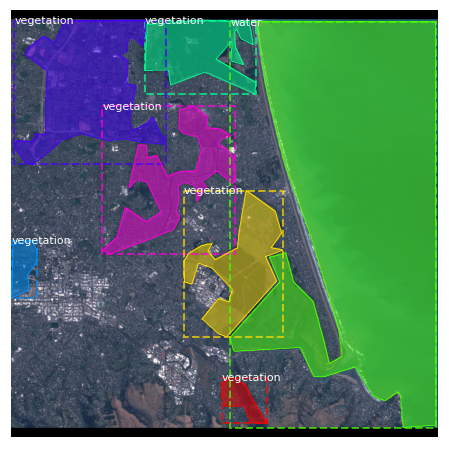

In [92]:
# test_num = random.choice(range(len(dataset_val.image_ids)))
test_num = 45
print("NUMBER: ", test_num)

image_id = dataset_val.image_ids[test_num]
test_img, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", test_img)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(test_img, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


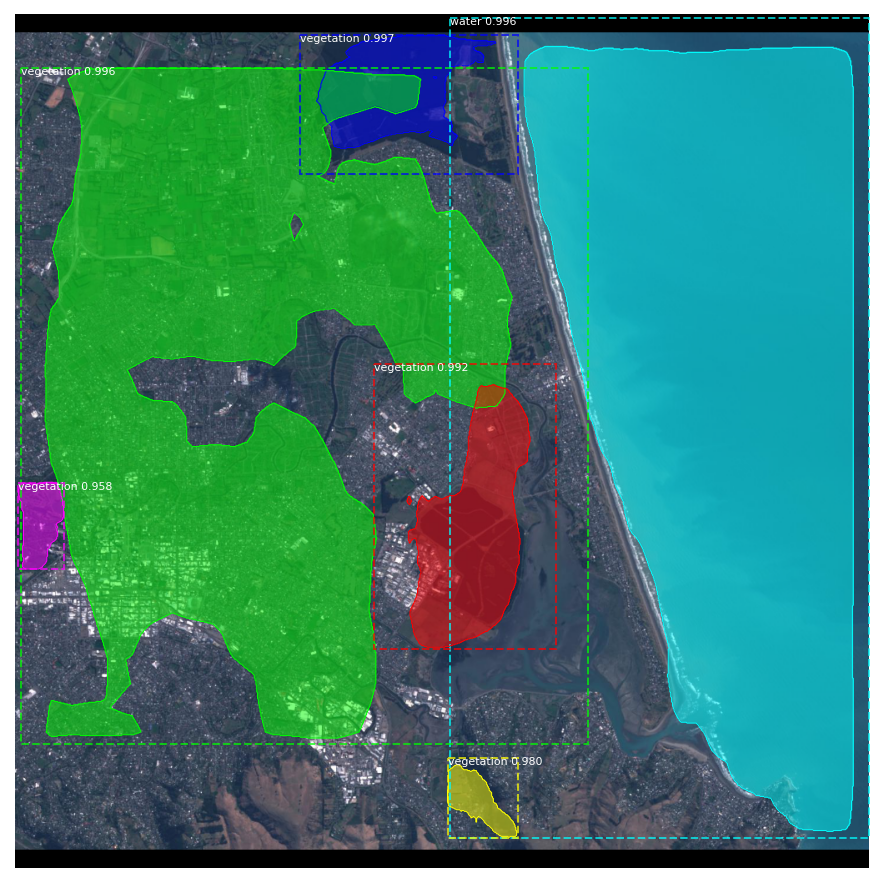

In [93]:
results = model.detect([test_img], verbose=1)

r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

Save path: /home/ucsail/rural_images/MASK_RCNN/prediction_examples/Christchurch


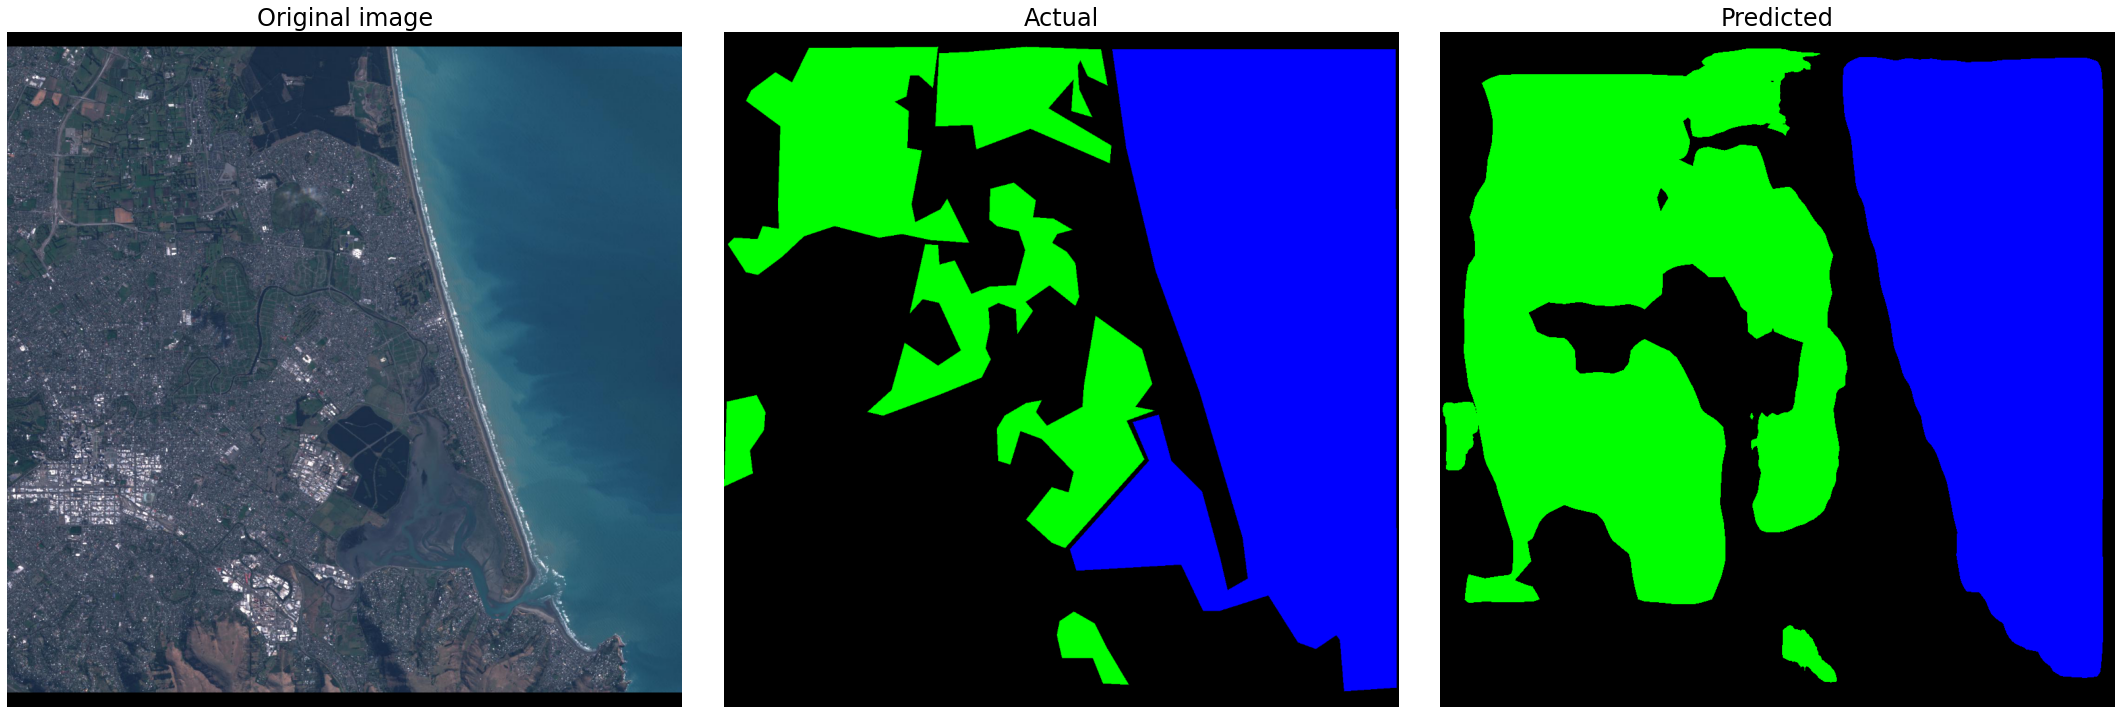

In [96]:
water_vege_converter = {
    1: (0, 0, 255),  # water
    2: (0, 255, 0)  # vegetation
}
test_fname = os.path.basename(os.path.normpath(dataset_val.image_reference(test_num)))
test_target_fpath = os.path.join(dataset_dir, "val_class_images", test_fname)
test_rgb_target_img = semantic_utils.convert_to_rgb(np.array(load_img(test_target_fpath))[:, :, 0], water_vege_converter)
test_rgb_target_img_square = semantic_utils.resize_image_to_square(test_rgb_target_img, max_dim=1024)

test_pred_img = semantic_utils.convert_mrcnn_instances_to_semantic(r, config)
test_rgb_pred_img = semantic_utils.convert_to_rgb(test_pred_img, water_vege_converter)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
fig.tight_layout()
for a in ax:
    a.set_axis_off()

ax[0].imshow(test_img)
ax[0].set_title("Original image", fontsize=24)
ax[1].imshow(test_rgb_target_img_square)
ax[1].set_title("Actual", fontsize=24)
ax[2].imshow(test_rgb_pred_img)
ax[2].set_title("Predicted", fontsize=24)

save_path = os.path.join(ROOT_DIR, "MASK_RCNN", "prediction_examples", "Christchurch")
print("Save path:", save_path)
# plt.savefig(save_path, bbox_inches='tight')
plt.show();

In [91]:
print("THESE ARE METRICS FOR A SINGLE IMAGE!!!")
test_paths = [test_target_fpath]
test_pred_imgs = np.expand_dims(test_pred_img, axis=0)
test_result = semantic_utils.compute_metrics(test_paths, test_pred_imgs, config.NUM_CLASSES, config.IMAGE_MAX_DIM, display=True)
print("THESE ARE METRICS FOR A SINGLE IMAGE!!!")

THESE ARE METRICS FOR A SINGLE IMAGE!!!
All classes  |   mIOU: 0.5153   mF1 score: 0.6705
             |
Class 0      |    IOU: 0.3603    F1 score: 0.5298
Class 1      |    IOU: 0.6439    F1 score: 0.7834
Class 2      |    IOU: 0.4629    F1 score: 0.6329

Overall confusion matrix:
[[200626  26019 124392]
 [159704 340314   2477]
 [ 46024      0 149020]]

(rows=actual, cols=pred)
THESE ARE METRICS FOR A SINGLE IMAGE!!!


# Evaluation of pixel-wise classifications

In [ ]:
target_image_paths = []
pred_images = np.zeros(shape=(len(dataset_val.image_ids), config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM), dtype=np.uint8)

print(f"Number of images processed:", end="", flush=True)

for image_id in dataset_val.image_ids:
    # print progress
    if (image_id + 1) % 10 == 0 or (image_id + 1) == len(dataset_val.image_ids):
        print(f"  {image_id + 1}", end="", flush=True)
    
    # get target (mask) image filepath and append to list
    original_image_path = dataset_val.image_reference(image_id)
    original_image = np.array(load_img(original_image_path))
    original_image_square = utils.resize_image(original_image, max_dim=config.IMAGE_MAX_DIM)[0]
    image_filename = os.path.basename(os.path.normpath(original_image_path))
    
    target_image_path = os.path.join(dataset_dir, "val_class_images", image_filename)
    target_image_paths.append(target_image_path)
    
    # Predict instances using Mask R-CNN and convert to 2D class map
    result = model.detect([original_image_square], verbose=False)[0]
    pred_image = semantic_utils.convert_mrcnn_instances_to_semantic(result, config)
    
    # Write predicted 2D class map to 3D array
    pred_images[image_id, :, :] = pred_image

In [ ]:
results = semantic_utils.compute_metrics(target_image_paths, pred_images, config.NUM_CLASSES, config.IMAGE_MAX_DIM, display=True)

In [ ]:
semantic_utils.print_metric_results(results, config.NUM_CLASSES)